## Gaussian Process Regression wit GPy

In [45]:
import pandas as pd

### 1. Read the data

In [46]:
all_positions = pd.read_csv('../data/positions_xyz_128px_024.csv', delimiter=',')
all_positions

,x,y,z
0,6.000000,4.000000,16.150000
1,11.500000,4.000000,16.150000
2,11.500000,4.000000,16.150000
3,11.500000,4.000000,16.150000
4,11.499730,4.558342,16.369990
...,...,...,...
2725,3.284046,-0.186768,6.703153
2726,3.236364,-0.105325,6.592360
2727,3.188950,0.048992,6.485370
2728,3.141816,0.273443,6.382246


In [47]:
all_red_ball_positions = pd.read_csv('../data/red_ball_coordinates_128px_024.csv', delimiter=',')
all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,68.500000,118.500000,74.736842,87.157895,NaN,NaN,NaN,NaN,74.722222,46.777778,33.500000,90.50,NaN,NaN
1,68.500000,118.500000,77.625000,95.000000,NaN,NaN,NaN,NaN,75.357143,51.785714,32.450000,95.05,NaN,NaN
2,68.500000,118.500000,77.526316,100.052632,NaN,NaN,NaN,NaN,75.400000,56.600000,33.520000,99.40,NaN,NaN
3,68.500000,118.500000,77.722222,103.777778,NaN,NaN,NaN,NaN,75.500000,59.500000,34.100000,103.60,NaN,NaN
4,68.500000,118.500000,78.565217,108.173913,NaN,NaN,NaN,NaN,75.500000,63.000000,34.238095,107.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,68.500000,118.625000,61.000000,69.000000,NaN,NaN,NaN,NaN,60.750000,46.250000,NaN,NaN,NaN,NaN
2722,68.500000,118.625000,61.000000,69.000000,NaN,NaN,NaN,NaN,60.750000,46.250000,NaN,NaN,NaN,NaN
2723,68.500000,118.625000,61.000000,69.000000,NaN,NaN,NaN,NaN,54.666667,23.333333,NaN,NaN,NaN,NaN
2724,68.555556,119.111111,60.500000,69.000000,NaN,NaN,NaN,NaN,54.666667,23.333333,NaN,NaN,NaN,NaN


In [48]:
xyz_positions = pd.read_csv('../data/positions_xyz_128px_024.csv', delimiter=',')
xyz_positions = xyz_positions.iloc[4:]
red_ball_positions = pd.read_csv('../data/red_ball_coordinates_128px_024.csv', delimiter=',')
red_ball_positions.shape,  xyz_positions.shape

((2726, 14), (2726, 3))

### 2. Handle Missing Values

In [49]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_all = imputer.fit_transform(all_red_ball_positions)
y_all = imputer.fit_transform(all_positions)
X = imputer.fit_transform(red_ball_positions)
y = imputer.fit_transform(xyz_positions)

### 3. Prepare the Data

In [50]:
total_samples = len(X)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X[:train_samples]
y_train = y[:train_samples]

X_test = X[train_samples:]
y_test = y[train_samples:]

In [51]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2180, 14), (546, 14), (2180, 3), (546, 3))

In [52]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = scaler_y.fit_transform(y_train)
X_scaled_train.shape, y_scaled_train.shape

((2180, 14), (2180, 3))

### 4. Train the Model

In [53]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy
For normal regression tasks

In [54]:
kernel = RBF(input_dim=14)
model = GPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model.optimize(messages=True)

In [55]:
model

GP_regression.,value,constraints,priors
rbf.variance,0.6202886751715179,+ve,
rbf.lengthscale,1.870920940266143,+ve,
Gaussian_noise.variance,0.2554515682680532,+ve,


#### 4.2 Train Sparse GP Regression Model with GPy
Model for large datasets

In [56]:
from GPy.models import SparseGPRegression

kernel = RBF(input_dim=14)
model_sparse = SparseGPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model_sparse.optimize(messages=True)

In [57]:
model_sparse

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 14)",,
rbf.variance,0.13780963604929838,+ve,
rbf.lengthscale,4.096585631025602,+ve,
Gaussian_noise.variance,0.4461460054436516,+ve,


### 5. Make Predictions

In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)


#### 5.1 Predict with GP Regression Model

In [59]:
y_pred_reg, y_var_reg = model.predict(X_scaled_test)
y_pred_reg = scaler_y.inverse_transform(y_pred_reg)
y_pred_reg

array([[ 1.26330364,  7.46675863, 11.48936577],
       [ 2.53815313,  6.03999894, 10.38388149],
       [ 2.49077867,  5.99789736, 10.63665613],
       ...,
       [ 3.8991946 ,  4.39979045,  8.33572934],
       [ 3.90586443,  4.61620367,  7.98978143],
       [ 4.48858086,  4.43983245,  7.20218526]])

#### 5.2 Predict with Sparse GP Regression Model

In [60]:
y_pred_sparse, y_var_sparse = model_sparse.predict(X_scaled_test)
y_pred_sparse = scaler_y.inverse_transform(y_pred_sparse)
y_pred_sparse

array([[ 3.52864362,  6.82216636,  9.58586001],
       [ 3.29428443,  6.32540897,  9.45463884],
       [ 3.31998447,  6.26363118,  9.54920123],
       ...,
       [ 5.00134239,  4.15016899, 14.19282673],
       [ 4.89548744,  4.19852638, 14.13538572],
       [ 4.05219207,  4.72864915,  8.98259215]])

### 6. Evaluate the Model

In [61]:
def evaluate_model(y_test_evaluate, y_pred_evaluate):
    mse = mean_squared_error(y_test_evaluate, y_pred_evaluate)
    r2 = r2_score(y_test_evaluate, y_pred_evaluate)
    mae = mean_absolute_error(y_test_evaluate, y_pred_evaluate)
    return mse, r2, mae


#### 6.1 Evaluate GP Regression Model

In [62]:
mse_reg, r2_reg, mae_reg = evaluate_model(y_test, y_pred_reg)
print("MSE:", mse_reg)
print("R2:", r2_reg)
print("MAE:", mae_reg)

MSE: 7.539766021881632
R2: 0.7201079835808675
MAE: 1.5586936197921328


#### 6.2 Evaluate Sparse GP Regression Model

In [63]:
mse_sparse, r2_sparse, mae_sparse = evaluate_model(y_test, y_pred_sparse)
print("MSE:", mse_sparse)
print("R2:", r2_sparse)
print("MAE:", mae_sparse)

MSE: 12.940087638037676
R2: 0.5830515584027273
MAE: 2.403290598294865


### 7. Visualize results

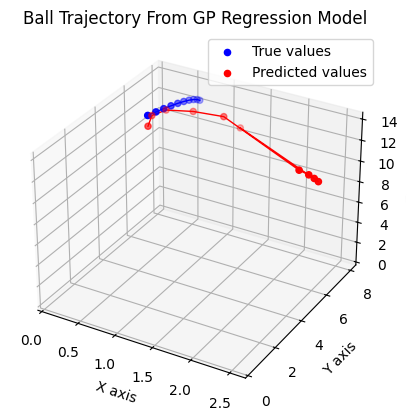

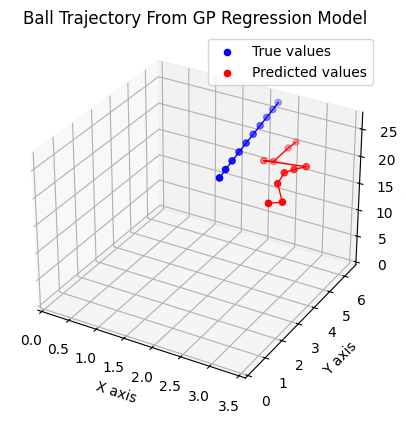

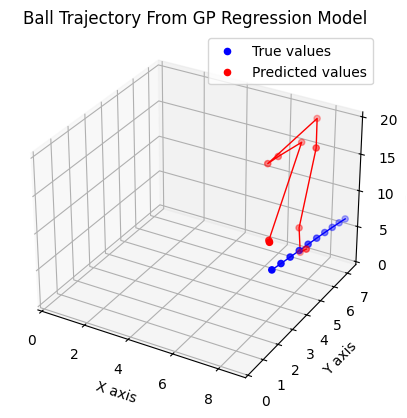

In [64]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred_reg, "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test[100:110], y_pred_reg[100:110], "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test[220:230], y_pred_reg[220:230], "Ball Trajectory From GP Regression Model")